# Predict the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 652.56
- MAE: 508.45289917295
- MAPE: 1.50 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> CMG - 8 1 1
split = 2  # 8 1 1
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1247,2024-02-26,39900,40200,39500,40000,102000,CMG
1248,2024-02-27,40000,40200,39400,40200,135100,CMG
1249,2024-02-28,40200,40200,39600,40000,177200,CMG
1250,2024-02-29,40000,40000,37600,39950,347700,CMG


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [39]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [40]:
# Shape of the dataframe
df.shape

(1252, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,25239.357827,25802.539137
std,8728.202150,8986.348803
min,10780.000000,10880.000000
25%,17455.000000,17710.000000
50%,25175.000000,25925.000000
75%,32340.000000,33325.000000
max,43600.000000,44150.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

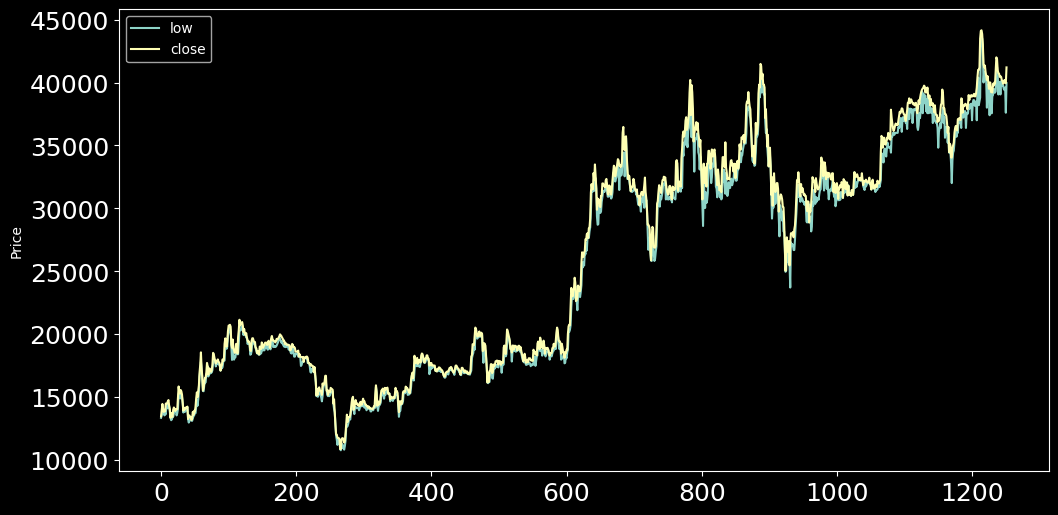

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-0.7532061524789402,
 0.832482618456889,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 19254.366836531663)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.456
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.487
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


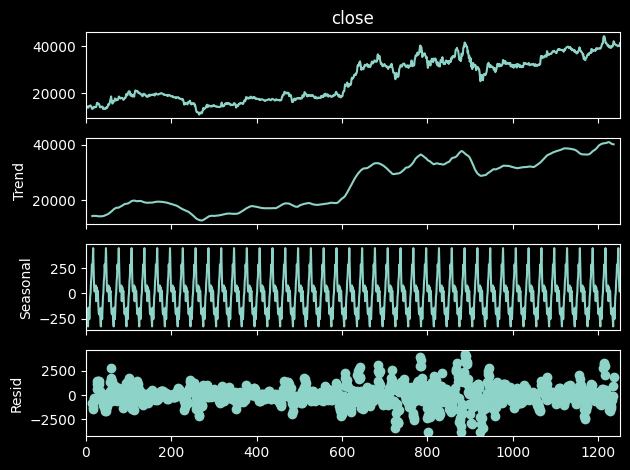

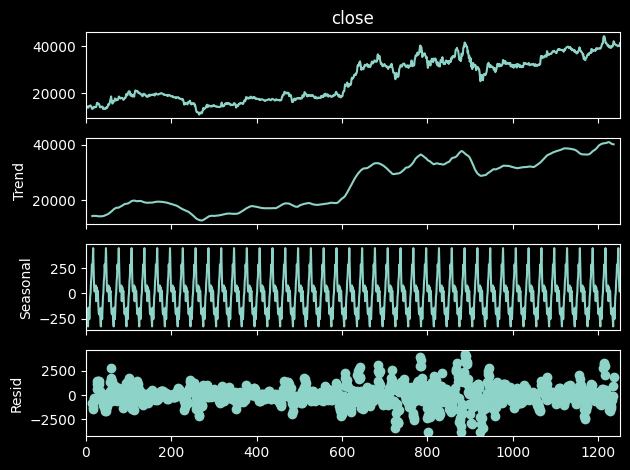

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-24.114490053311997,
 0.0,
 1,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 15381.775912686624)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

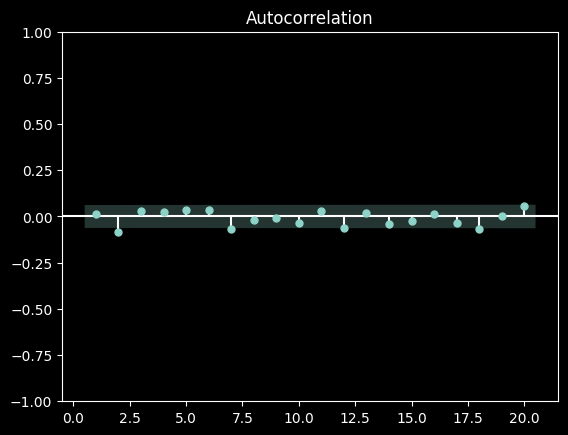

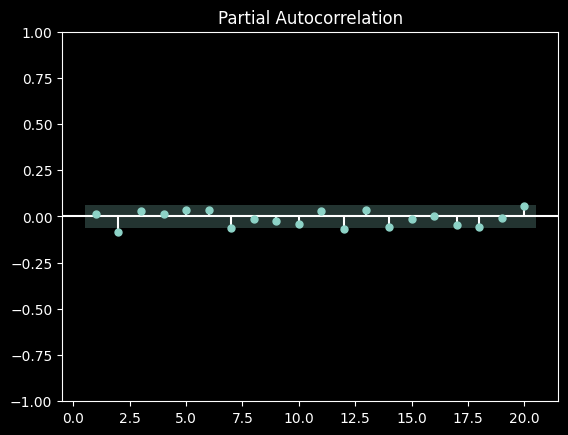

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=15728.892, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=15732.297, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=15734.889, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=15734.765, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=15731.163, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=15727.084, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=15733.260, Time=0.14 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=15734.306, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=15727.195, Time=0.38 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=15736.217, Time=0.38 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=15732.501, Time=0.13 sec
 ARIMA(2,1,1)(0,0,1)[5] intercept   : AIC=15732.200, Time=0.10 sec
 ARIMA(3,1,2)(0,0,1)[5] intercept   : AIC=15735.706, Time=0.33 sec
 ARIMA(2,1,3)(0,0,1)[5] intercept   : AIC=15734.575, Time=0.38 sec
 ARIMA(1,1,1)(0,0,1

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1001
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 5)   Log Likelihood               -7856.739
Date:                             Sun, 26 May 2024   AIC                          15725.478
Time:                                     03:37:37   BIC                          15754.924
Sample:                                          0   HQIC                         15736.669
                                            - 1001                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4792      0.065    -22.832      0.000      -1.606      -1.352
ar.L2         -0.8496      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([32162.6166116 , 31619.12890255, 31557.51873328, 32096.37763489,
       31606.16101209, 32182.54736431, 32144.15223329, 31891.88791293,
       31741.93955121, 32181.94277223, 32107.03224877, 32444.01143203,
       32219.36173436, 32144.48175739, 32883.00223344, 31929.19633041,
       32659.29319802, 31966.63713547, 32107.04038322, 31966.63712529,
       31891.75538157, 32256.80387047, 32107.04038786, 31966.63712346,
       32331.68561126, 33651.47629819, 32481.44909348, 32921.37932245,
       32546.97061694, 32771.61584025, 32985.96482415, 33136.66432811,
       33061.78258701, 33211.54606921, 33024.34171646, 33061.78258701,
       33061.78258701, 33061.78258701, 32621.85235804, 32481.44909348,
       32331.68561128, 32948.5239536 , 32584.41148749, 32696.73409915,
       32883.00243013, 32921.37932245, 32921.37932245, 32809.0567108 ,
       32809.0567108 , 32696.73409915, 32369.12648183, 32771.61584025,
       32659.2932286 , 32546.97061694, 32444.00822293, 32444.00822293,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([39641.43050404, 38058.95863721, 39504.34350759, 38770.21281049,
       39290.89969255, 39361.83429234, 38190.85282717, 39071.17484096,
       38041.3660213 , 39361.22970026, 38041.410231  , 38631.11529047,
       38406.46559281, 38078.85973962, 38406.46666138, 38340.94541216,
       37311.3213639 , 38078.85925281, 38041.41836546, 37461.08487855,
       37423.64400539, 37311.32139477, 37311.32139436, 36946.27290666,
       35476.71873749, 36656.10615985, 36946.27290661, 37311.32139448,
       36946.27290661, 37826.13336454, 37975.89684675, 38443.90772862,
       37311.32139448, 37788.69249399, 36216.17593088, 36871.39116551,
       37021.15464771, 36796.50942441, 35851.12744301, 36581.22441874,
       35111.67024964, 35186.55199074, 35186.55199074, 34306.69153281,
       32845.56155958, 34531.33675611, 35111.67024964, 35261.43373184,
       35916.64896648, 36581.22441874, 36721.62768331, 36291.05767198,
       36721.62768331, 36581.22441874, 37535.96661778, 37348.76226503,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[39377.23494454 39434.55930518 39430.86858262 39447.31343742
 39483.02714322 39499.55857807 39519.08289376 39540.02302577
 39560.31672242 39580.86829064 39601.31808445 39621.80800891
 39642.28211071 39662.76245101 39683.24033161 39703.71918202
 39724.19765005 39744.67626885 39765.1548282  39785.633411
 39806.11198455 39826.59056174 39847.0691375  39867.54771382
 39888.02628992 39908.50486611 39928.98344226 39949.46201843
 39969.94059459 39990.41917075]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

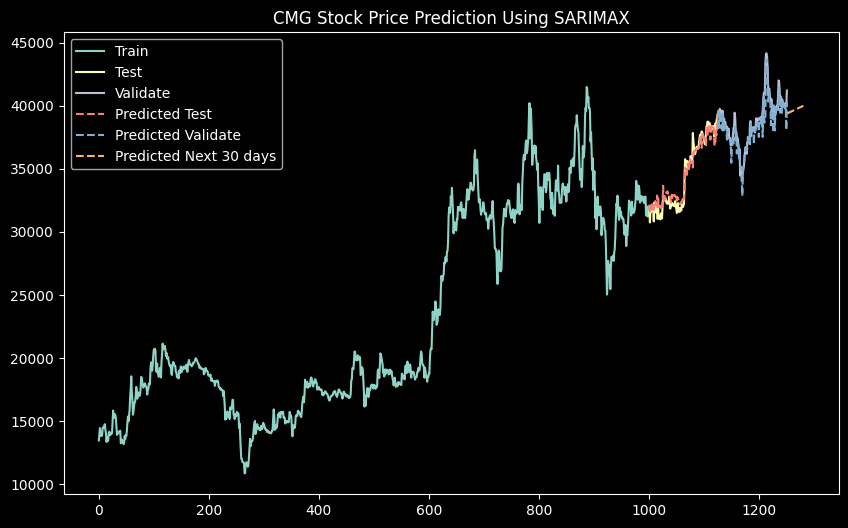

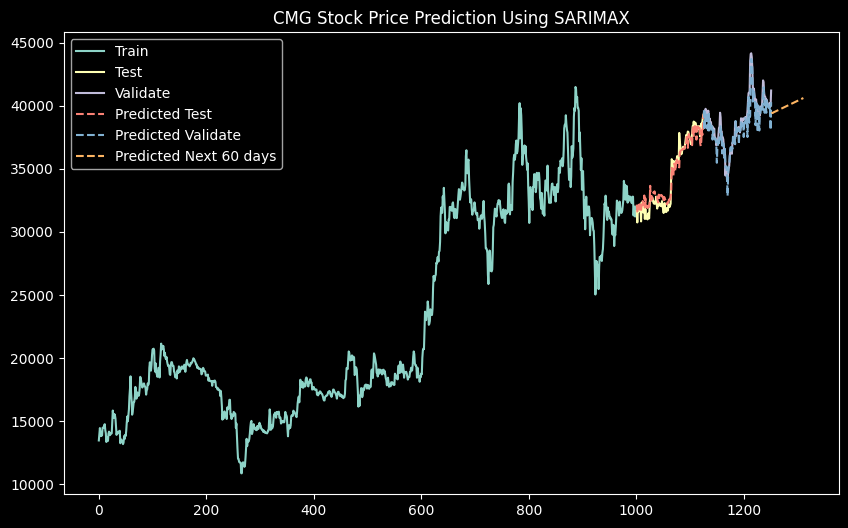

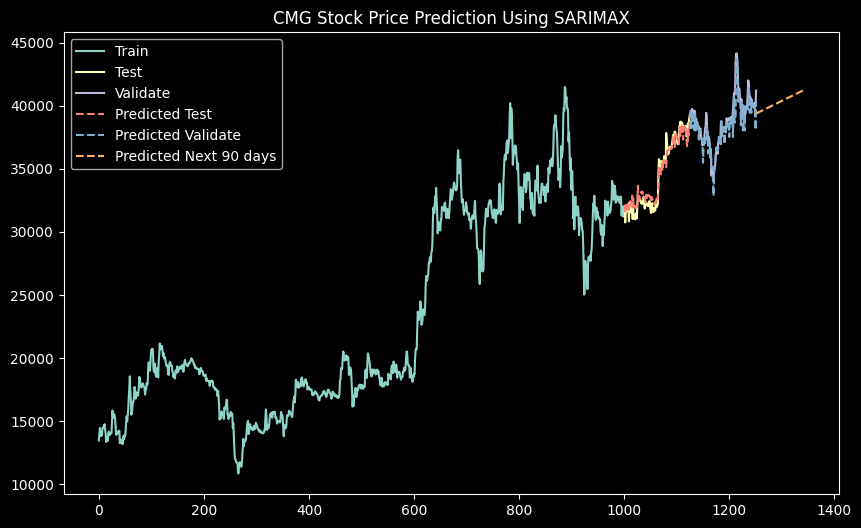

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 652.5606701285262
MAE on test data: 508.45289917295
MAPE on test data: 1.5000311401341224 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 839.3302729890412
MAE on validation data: 534.3736577330687
MAPE on validation data: 1.3563102447769613 %
